# 5章 教師あり学習：回帰

## 5.1 １次元入力の直線モデル

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# 教師データ作成

np.random.seed(seed=1) # 乱数を固定

X_min = 4 # Xの加減
X_max = 30 # Xの上限
X_n = 16 # データの個数

X = 5 + 25 * np.random.rand(X_n) # 年齢Xの生成
Prm_c = [170, 108, 0.2] # 生成パラメータ

# 身長の式
# 170 - 108 * exp(-0.2X) + 4 * 標準正規分布に従う16個の数(np.randn)
T = Prm_c[0] - Prm_c[1] * np.exp(-Prm_c[2] * X) + 4 * np.random.randn(X_n)

# 複数のndarrayをnpzで保存
np.savez('ch5_data.npz', X = X, X_min = X_min, X_max = X_max, X_n = X_n, T = T)

In [67]:
X

array([15.42555012, 23.00811234,  5.00285937, 12.55831432,  8.66889727,
        7.30846487,  9.65650528, 13.63901818, 14.91918686, 18.47041835,
       15.47986286, 22.13048751, 10.11130624, 26.95293591,  5.68468983,
       21.76168775])

In [68]:
T

array([170.91013145, 160.67559882, 129.00206616, 159.70139552,
       155.46058905, 140.56134369, 153.65466385, 159.42939554,
       164.70423898, 169.64527574, 160.71257522, 173.28709855,
       159.31193249, 171.51757345, 138.9570433 , 165.8744074 ])

In [69]:
# 小数点以下第二位で四捨五入
np.round(X, 2)

array([15.43, 23.01,  5.  , 12.56,  8.67,  7.31,  9.66, 13.64, 14.92,
       18.47, 15.48, 22.13, 10.11, 26.95,  5.68, 21.76])

In [70]:
np.round(T, 2)

array([170.91, 160.68, 129.  , 159.7 , 155.46, 140.56, 153.65, 159.43,
       164.7 , 169.65, 160.71, 173.29, 159.31, 171.52, 138.96, 165.87])

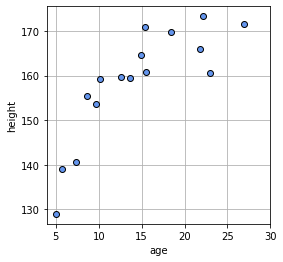

In [71]:
# グラフに表示
plt.figure(figsize=(4,4))
plt.plot(X, T, marker='o', linestyle='None', markeredgecolor='black', color='cornflowerblue')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.xlabel('age')
plt.ylabel('height')
plt.show()

### 5.1.1 直線モデル

$y(x)=w_0x+w_1$

### 5.1.2 二乗誤差関数

$\displaystyle J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n-t_n)^2$

- $J$は平均二乗誤差（mean squared error, MSE）という

In [72]:
from mpl_toolkits.mplot3d import Axes3D

In [73]:
# 誤差関数の定義
def mse_line(x,t,w):
    y = w[0]*x + w[1]
    mse = np.mean((y-t)**2)
    return mse

In [74]:
xn = 100 # 等高線表示の解像度
w0_range = [-25, 25]
w1_range = [120, 170]

# linspace(start,stop,num)で等差数列を作成
w0 = np.linspace(w0_range[0], w0_range[1], xn)
w1 = np.linspace(w1_range[0], w1_range[1], xn)

# 格子列を作成
ww0, ww1 = np.meshgrid(w0, w1)

In [75]:
# 参考
print('linspace','w0='+str(w0.shape),'w1='+str(w1.shape))
print('meshgrid','ww0='+str(ww0.shape),'ww1='+str(ww1.shape))

linspace w0=(100,) w1=(100,)
meshgrid ww0=(100, 100) ww1=(100, 100)


In [76]:
# 格子点に基づく平均二乗誤差の計算結果をJ[i1, i0]に入れる
J = np.zeros((len(w0), len(w1)))
for i0 in range(len(w0)):
    for i1 in range(len(w1)):
        J[i1, i0] = mse_line(X, T, (w0[i0], w1[i1]))

In [77]:
J.shape

(100, 100)

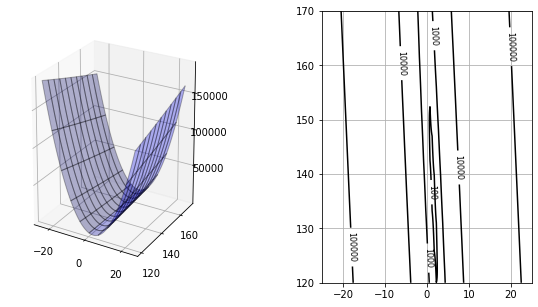

In [78]:
# 可視化

# グラフのサイズ
plt.figure(figsize=(9.4,5))

# グラフの余白、幅を調整する
# wspace : the amount of width reserved for space between subplots,
plt.subplots_adjust(wspace=0.5)

# subplot(行数、列数、数)
ax = plt.subplot(1,2,1,projection='3d')

# ３次元のグラフを作成する 
ax.plot_surface(ww0, ww1, J, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')

# 目盛りの調整
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120, 140, 160])
ax.view_init(20, -60)

# 等高線の表示
plt.subplot(1, 2, 2)
cont = plt.contour(ww0, ww1, J, 30, colors='black',levels=[100, 1000, 10000, 100000])
cont.clabel(fmt='%d', fontsize=8)
plt.grid(True)
plt.show()

### 5.1.3 パラメータを求める（勾配法）

In [79]:
# 平均二乗誤差の勾配
def dmse_line(x, t, w):
    y = w[0] * x + w[1]
    d_w0 = 2 * np.mean((y-t)*x)
    d_w1 = 2 * np.mean(y-t)
    return d_w0, d_w1

In [80]:
# w = [10,165の勾配]
d_w = dmse_line(X,T,[10,165])
print(np.round(d_w,1))

[5046.3  301.8]


In [81]:
# 勾配法
def fit_line_num(x, t):
    w_init = [10.0, 165.0] #初期パラメータ
    alpha = 0.001 # 学習率
    tau_max = 100000 # 繰り返しの最大数
    eps = 0.1 # 繰り返しをやめる勾配の絶対値のしきい値
    w_hist = np.zeros([tau_max, 2])
    w_hist[0, :] = w_init # wの初期値をw_histに代入
    
    for tau in range(1, tau_max):
        dmse = dmse_line(x, t, w_hist[tau - 1])
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        if max(np.absolute(dmse)) < eps: # 終了判定
            break
    
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w_hist = w_hist[:tau, :]
    
    return w0, w1, dmse, w_hist

繰り返し回数13820
W=[-0.005794, 0.099991]
MSE=49.027452


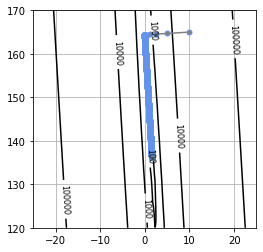

In [82]:
plt.figure(figsize=(4,4))
# MSEの等高線表示

wn = 100 # 等高線解像度
w0_range = [-25, 25]
w1_range = [120, 170]

w0 = np.linspace(w0_range[0], w0_range[1], wn)
w1 = np.linspace(w1_range[0], w1_range[1], wn)

ww0, ww1 = np.meshgrid(w0, w1)

J = np.zeros((len(w0),len(w1)))

for i0 in range(wn):
    for i1 in range(wn):
        J[i1, i0] = mse_line(X, T, (w0[i0], w1[i1]))
cont = plt.contour(ww0, ww1, J, 30, colors='black', levels=(100,1000,10000,100000))
cont.clabel(fmt='%1.0f',fontsize=8)
plt.grid(True)

# 勾配法呼び出し
W0, W1, dMSE, W_history = fit_line_num(X, T)

# 結果表示
print('繰り返し回数{0}'.format(W_history.shape[0]))
print('W=[{0:.6f}, {1:.6f}]'.format(dMSE[0],dMSE[1]))
print('MSE={0:.6f}'.format(mse_line(X,T,[W0,W1])))

plt.plot(W_history[:,0], W_history[:,1], '.-', color='gray', markersize=10, markeredgecolor='cornflowerblue')
plt.show()

w0=1.540, w1=136.176
SD=7.002 cm


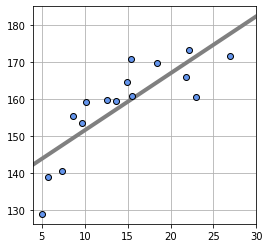

In [83]:
# 線の表示
def show_line(w):
    xb = np.linspace(X_min, X_max, 100)
    y = w[0] * xb + w[1]
    plt.plot(xb, y, color=(.5, .5, .5), linewidth=4)

plt.figure(figsize=(4, 4))
W = np.array([W0, W1])
mse = mse_line(X, T, W)
print('w0={0:.3f}, w1={1:.3f}'.format(W0, W1))
print('SD={0:.3f} cm'.format(np.sqrt(mse)))
show_line(W)
plt.plot(X, T, marker='o',linestyle='None', color='cornflowerblue',markeredgecolor='black')
plt.xlim(X_min,X_max)
plt.grid(True)
plt.show()


### 5.1.4 直線モデルパラメータの解析解

In [84]:
# 解析解を求める
def fit_line(x,t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t*x)
    mxx = np.mean(x*x)
    w0 = (mtx - mt * mx) / (mxx - mx**2)
    w1 = mt - w0 * mx
    return np.array([w0,w1])

w0=1.558, w1=135.872
SD=7.001cm


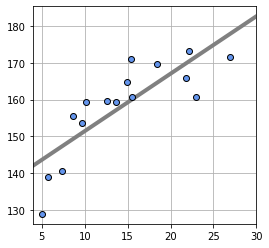

In [85]:
W = fit_line(X, T)
print('w0={0:.3f}, w1={1:.3f}'.format(W[0],W[1]))
mse = mse_line(X, T, W)
print('SD={0:.3f}cm'.format(np.sqrt(mse)))
plt.figure(figsize=(4,4))
show_line(W)
plt.plot(X, T, marker='o',linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

## 5.2 ２次元入力の面モデル

In [86]:
# 二次元データ作成
X0 = X
X0_min = 5
X0_max = 30
np.random.seed(seed=1) # 乱数を固定
X1 = 23 * (T / 100) ** 2 + 2 * np.random.randn(X_n)
X1_min = 40
X1_max = 75

In [87]:
print(np.round(X0,2))
print(np.round(X1,2))
print(np.round(T,2))

[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
[70.43 58.15 37.22 56.51 57.32 40.84 57.79 56.94 63.03 65.69 62.33 64.95
 57.73 66.89 46.68 61.08]
[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


In [88]:
# ２次元データの表示
def show_data2(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot([x0[i],x0[i]],[x1[i],x1[i]], [120,t[i]], color='gray')
    ax.plot(x0,x1,t,'o',color='cornflowerblue', markeredgecolor='black',markersize=6,markeredgewidth=0.5)
    ax.view_init(elev=35,azim=-75)

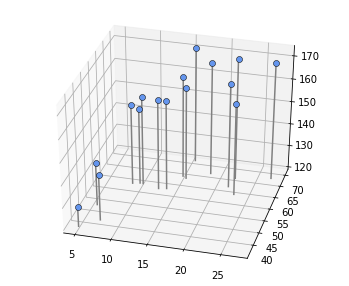

In [89]:
plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1,projection='3d')
show_data2(ax,X0,X1,T)
plt.show()

### 5.2.1 データの表し方

### 5.2.2 面モデル

In [90]:
# ２変数の直線モデル
def show_plane(ax,w):
    px0 = np.linspace(X0_min,X0_max,5)
    px1 = np.linspace(X1_min,X1_max,5)
    px0, px1 = np.meshgrid(px0,px1)
    y = w[0]*px0 + w[1]*px1 + w[2]
    ax.plot_surface(px0,px1,y,rstride=1,cstride=1,alpha=0.3,color='blue',edgecolor='black')

In [91]:
# ２変数の誤差関数モデル
def mse_plane(x0,x1,t,w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    mse = np.mean((y-t)**2)
    return mse

SD=12.88cm


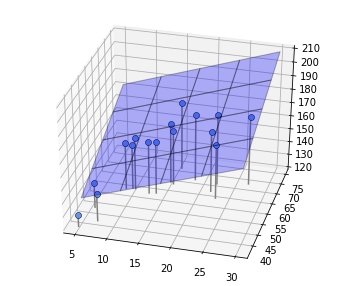

In [92]:
# グラフの描写
plt.figure(figsize=(6,5))

# グラフの数と次元を指定
ax = plt.subplot(1, 1, 1, projection='3d')

# w[0],w[1],w[2]の値を決定
W = [1.5, 1, 90]

# 描画
show_plane(ax,W)
show_data2(ax,X0,X1,T)
mse = mse_plane(X0,X1,T,W)
print('SD={0:.2f}cm'.format(np.sqrt(mse)))
plt.show()

### 5.2.3 面モデルパラメータの解析解

In [93]:
# 解析解
def fit_plane(x0,x1,t):
    # 共分散
    c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
    c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
    c_x0x1 = np.mean(x0 * x1) -np.mean(x0) * np.mean(x1)
    # 分散
    v_x0 = np.var(x0)
    v_x1 = np.var(x1)
    # 解析解
    w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1**2 - v_x0 * v_x1)
    w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1**2 - v_x0 * v_x1)
    w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
    # 戻り値
    return np.array([w0,w1,w2])

w0=0.5, w1=0.5, w2=89.0
SD=2.55cm


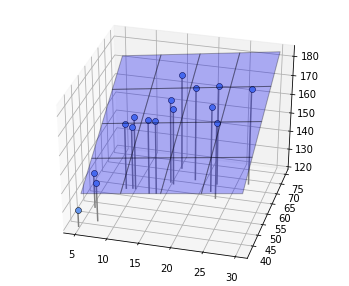

In [94]:
plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1,projection='3d')
W = fit_plane(X0,X1,T)
print('w0={0:.1f}, w1={0:.1f}, w2={2:.1f}'.format(W[0],W[1],W[2]))

show_plane(ax,W)
show_data2(ax,X0,X1,T)
mse = mse_plane(X0,X1,T,W)
print('SD={0:.2f}cm'.format(np.sqrt(mse)))
plt.show()

## 5.3 D次元線形回帰モデル

### 5.3.1 D次元線形回帰モデル

### 5.3.2 パラメータの解析解

### 5.3.3 原点を通らない面への拡張

## 5.4 線形基底関数モデル

In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
outfile = np.load('ch5_data.npz')
X = outfile['X']
X_min = 0
X_max = outfile['X_max']
X_n = outfile['X_n']
T = outfile['T']

##### ガウス基底関数を用いた線形モデル

In [97]:
def gauss(x, mu, s):
    return np.exp(-(x-mu)**2 / (2*s**2))

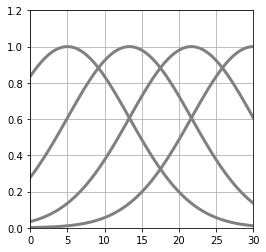

In [98]:
M = 4 # ガウス関数の個数

plt.figure(figsize=(4,4))

mu = np.linspace(5, 30, M) # ガウス関数の中心位置を決める（5~30の間のM個、等差）
s = mu[1] - mu[0] # 関数の広がりの程度
xb = np.linspace(X_min, X_max, 100) # 横軸のxを100個

for j in range(M):
    y = gauss(xb, mu[j], s)
    plt.plot(xb, y, color='gray', linewidth=3)

plt.grid(True)
plt.xlim(X_min,X_max)
plt.ylim(0,1.2)
plt.show()

#####  パラメータwを求める 

In [99]:
# 線形基底関数モデル
def gauss_func(w,x):
    m = len(w) - 1
    mu = np.linspace(5, 30, m)
    s = mu[1] - mu [0]
    y = np.zeros_like(x)
    for j in range(m):
        y = y + w[j] * gauss(x, mu[j], s)
    y = y + w[m]
    return y

In [100]:
# 線形基底関数モデルMSE
def mse_gauss_func(x,t,w):
    y = gauss_func(w,x)
    mse = np.mean((y-t)**2)
    return mse

In [101]:
# 線形基底関数モデル 厳密解
def fit_gauss_func(x, t, m):
    mu = np.linspace(5, 30, m)
    s =mu[1] - mu[0]
    n = x.shape[0]
    phi = np.ones((n,m+1))
    for j in range(m):
        phi[:,j] = gauss(x,mu[j],s)
    phi_T = np.transpose(phi)
    
    b = np.linalg.inv(phi_T.dot(phi))
    c = b.dot(phi_T)
    w = c.dot(t)
    return w

In [102]:
# ガウス基底関数
def show_gauss_func(w):
    xb = np.linspace(X_min, X_max, 100)
    y = gauss_func(w, xb)
    plt.plot(xb, y, c=[.5, .5, .5], lw=4)

W=[29.4 75.7  2.9 98.3 54.9]
SD=3.98cm


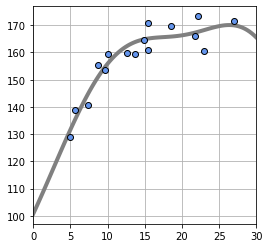

In [103]:
# 計算
plt.figure(figsize=(4,4))

M = 4
W = fit_gauss_func(X, T, M)
show_gauss_func(W)

plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)

mse = mse_gauss_func(X, T, W)
print('W=' + str(np.round(W,1)))
print('SD={0:.2f}cm'.format(np.sqrt(mse)))

plt.show()

## 5.5 オーバーフィッティングの問題

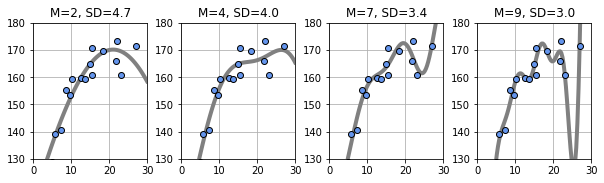

In [104]:
# M（基底関数の数）が変わるとSD（誤差の標準偏差）はどうなるか？

plt.figure(figsize=(10,2.5))
plt.subplots_adjust(wspace=0.3)

M = [2,4,7,9]

for i in range(len(M)):
    plt.subplot(1, len(M), i+1)
    W = fit_gauss_func(X, T, M[i])
    show_gauss_func(W)
    
    plt.plot(X,T,marker='o',linestyle='None',color='cornflowerblue',markeredgecolor='black')
    plt.xlim(X_min,X_max)
    plt.grid(True)
    plt.ylim(130,180)
    
    mse = mse_gauss_func(X, T, W)
    
    plt.title('M={0:d}, SD={1:.1f}'.format(M[i], np.sqrt(mse)))
    
plt.show()

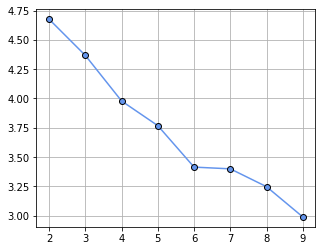

In [105]:
plt.figure(figsize=(5, 4))

M = range(2, 10)
mse2 = np.zeros(len(M))

for i in range(len(M)):
    W = fit_gauss_func(X, T, M[i])
    
    mse2[i] = np.sqrt(mse_gauss_func(X, T, W))
    
plt.plot(M, mse2, marker='o', color='cornflowerblue', markeredgecolor='black')
plt.grid(True)
plt.show()

##### 訓練データとテストデータに分割

In [106]:
# 訓練データとテストデータ
# テスト1/4,訓練3/4
X_test = X[:int(X_n / 4)]
T_test = T[:int(X_n / 4)]
X_train = X[int(X_n / 4):]
T_train = T[int(X_n / 4):]

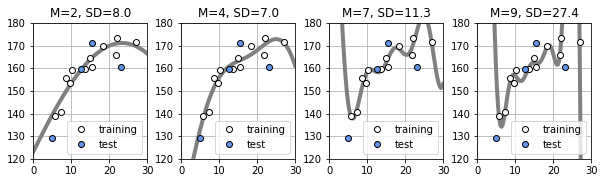

In [107]:
# メイン
plt.figure(figsize=(10, 2.5))
plt.subplots_adjust(wspace=0.3)

M = [2, 4, 7, 9]

for i in range(len(M)):
    plt.subplot(1, len(M), i + 1)
    W = fit_gauss_func(X_train, T_train, M[i])
    show_gauss_func(W)
    plt.plot(X_train, T_train, marker='o', linestyle='None', \
             color='white', markeredgecolor='black', label='training')
    plt.plot(X_test, T_test, marker='o', linestyle='None', \
            color='cornflowerblue', markeredgecolor='black', label='test')
    plt.legend(loc='lower right', fontsize=10, numpoints=1)
    plt.xlim(X_min,X_max)
    plt.ylim(120, 180)
    plt.grid(True)
    mse = mse_gauss_func(X_test, T_test, W)
    plt.title('M={0:d}, SD={1:.1f}'.format(M[i], np.sqrt(mse)))
    
plt.show()

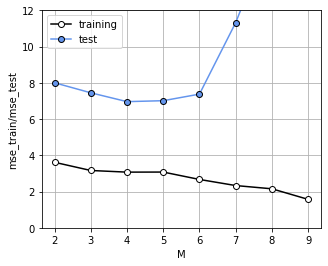

In [108]:
# Mの変化でSD（誤差）はどうなるか？

plt.figure(figsize=(5,4))

M = range(2, 10)

mse_train = np.zeros(len(M))
mse_test = np.zeros(len(M))

for i in range(len(M)):
    W = fit_gauss_func(X_train, T_train, M[i])
    mse_train[i] = np.sqrt(mse_gauss_func(X_train, T_train, W))
    mse_test[i] = np.sqrt(mse_gauss_func(X_test, T_test, W))

plt.plot(M, mse_train, marker='o', linestyle='-', markerfacecolor='white', \
         markeredgecolor='black', color='black', label='training')
plt.plot(M, mse_test, marker='o', linestyle='-', color='cornflowerblue', \
         markeredgecolor='black', label='test')

plt.legend(loc='upper left', fontsize=10)
plt.ylim(0,12)
plt.xlabel('M')
plt.ylabel('mse_train/mse_test')
plt.grid(True)
plt.show()

##### K分割交差検証

In [109]:
def kfold_gauss_func(x, t, m, k):
    n = x.shape[0] # データの個数（n,）
    mse_train = np.zeros(k) # k行のゼロ行列を作成
    mse_test = np.zeros(k) # k行のゼロ行列を作成
    for i in range(0, k):
        x_train = x[np.fmod(range(n), k) != i]
        t_train = t[np.fmod(range(n), k) != i]
        x_test = x[np.fmod(range(n), k) == i]
        t_test = t[np.fmod(range(n), k) == i]
        wm = fit_gauss_func(x_train, t_train, m) # 
        mse_train[i] = mse_gauss_func(x_train, t_train, wm)
        mse_test[i] = mse_gauss_func(x_test, t_test, wm)
    return mse_train, mse_test

In [110]:
# range(10)を5で割ったときの余り
np.fmod(range(10),5)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

In [111]:
M = 4
K = 4
kfold_gauss_func(X, T, M, K)

(array([12.87927851,  9.81768697, 17.2615696 , 12.92270498]),
 array([ 39.65348229, 734.70782012,  18.30921743,  47.52459642]))

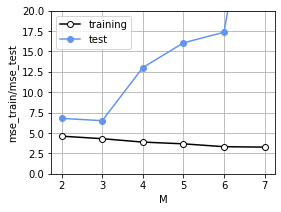

In [112]:
# mseが最小となるような最適なMを求める
M = range(2, 8)
K = 16

Cv_Gauss_train = np.zeros((K,len(M)))
Cv_Gauss_test = np.zeros((K,len(M)))

for i in range(0, len(M)):
    Cv_Gauss_train[:,i], Cv_Gauss_test[:,i] = kfold_gauss_func(X,T,M[i],K)

mean_Gauss_train = np.sqrt(np.mean(Cv_Gauss_train, axis=0))
mean_Gauss_test = np.sqrt(np.mean(Cv_Gauss_test, axis=0))

plt.figure(figsize=(4,3))
plt.plot(M,mean_Gauss_train,marker='o',linestyle='-',color='k',markerfacecolor='w',label='training')
plt.plot(M,mean_Gauss_test,marker='o',linestyle='-',color='cornflowerblue',label='test')
plt.legend(loc='upper left',fontsize=10)
plt.ylim(0,20)
plt.xlabel('M')
plt.ylabel('mse_train/mse_test')
plt.grid(True)
plt.show()

SD=4.37cm


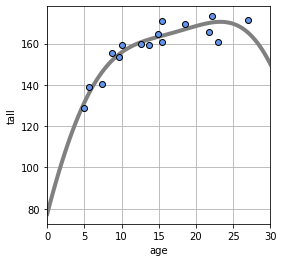

In [113]:
# 最適なMの下でのwを求める
M = 3
plt.figure(figsize=(4,4))
W = fit_gauss_func(X,T,M) # 厳密解を求める

show_gauss_func(W)

plt.plot(X,T,marker='o',linestyle='None',color='cornflowerblue',markeredgecolor='black')

plt.xlim(X_min, X_max)
plt.grid(True)
mse = mse_gauss_func(X, T, W)
print('SD={0:.2f}cm'.format(np.sqrt(mse)))
plt.xlabel('age')
plt.ylabel('tall')
plt.show()

## 5.6 新しいモデルの生成

In [114]:
# モデルA
def model_A(x,w):
    y = w[0] - w[1] * np.exp(-w[2]*x)
    return y

In [115]:
# 乱数を作成して、それを元にモデルA表示
def show_model_A(w):
    xb = np.linspace(X_min, X_max, 100)
    y = model_A(xb, w)
    plt.plot(xb, y, c=[.5,.5,.5], lw=4)

In [116]:
# モデルAのMSE
def mse_model_A(w,x,t):
    y = model_A(x,w)
    mse = np.mean((y-t)**2)
    return mse

In [117]:
# 最適化問題（関数の最小値/最大値）を求めるscipy.optimize
# wの最適パラメータを求める
from scipy.optimize import minimize

In [118]:
# 最小値を求める関数(mse_model_A)と、初期値(w_init)を与えて最適化問題を解く
def fit_model_A(w_init, x, t):
    res1 = minimize(mse_model_A, w_init, args=(x,t), method='powell')
    return res1.x

w0=169.0, w1=113.7, w2=0.2
SD=3.86cm


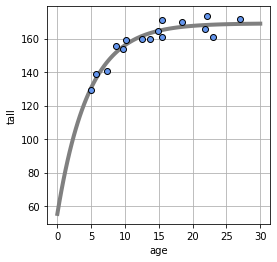

In [119]:
# 最適化関数に値を入れて

plt.figure(figsize=(4,4))

# ｗの初期値から最適解Wを求める
W_init = [100,0,0]
W = fit_model_A(W_init, X, T)
print('w0={0:.1f}, w1={1:.1f}, w2={2:.1f}'.format(W[0],W[1],W[2]))

# モデルの表示
show_model_A(W)

plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.grid(True)

# 誤差の表示
mse = mse_model_A(W, X, T)
print('SD={0:.2f}cm'.format(np.sqrt(mse)))

plt.xlabel('age')
plt.ylabel('tall')
plt.show()

## 5.7 モデルの選択

In [124]:
# 交差検証　model_A
def kfold_model_A(x, t, k):
    n = len(x)
    mse_train = np.zeros(k)
    mse_test = np.zeros(k)
    
    for i in range(0,k):
        x_train = x[np.fmod(range(n),k) != i]
        t_train = t[np.fmod(range(n),k) != i]
        x_test = x[np.fmod(range(n),k) == i]
        t_test = t[np.fmod(range(n),k) == i]
        # 誤差の最小値をとるパラメータwを求める最適化問題を解く
        wm = fit_model_A(np.array([169,113,0.2]), x_train, t_train)
        # 最適なwを使って誤差を求める
        mse_train[i] = mse_model_A(wm, x_train, t_train)
        mse_test[i] = mse_model_A(wm, x_test, t_test)
        
    return mse_train, mse_test

Gauss(M=3) SD=6.51cm
Model A SD=4.72cm


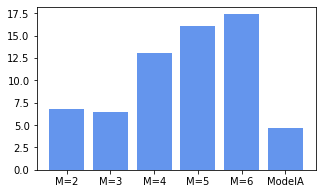

In [125]:
# 結果

# k分割交差検証の結果
K = 16
Cv_A_train, Cv_A_test = kfold_model_A(X, T, K)
mean_A_test = np.sqrt(np.mean(Cv_A_test)) # 誤差のSD

print('Gauss(M=3) SD={0:.2f}cm'.format(mean_Gauss_test[1]))
print('Model A SD={0:.2f}cm'.format(mean_A_test))

SD = np.append(mean_Gauss_test[0:5], mean_A_test)
M = range(6)
label = ['M=2', 'M=3', 'M=4', 'M=5', 'M=6', 'ModelA']

plt.figure(figsize=(5,3))
plt.bar(M, SD, tick_label=label, align='center', facecolor='cornflowerblue')
plt.show()